# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

ЦЕЛЬ:
- определить рыночную стоимость автомобиля

ЗАДАЧА:
- разработать модель, которая сможет определять рыночную стоимость автомобиля

ХОД РАБОТЫ:

1) Загрузка данных

2) Изучить данные

3) Подготовить выборки для обучения моделей

4) Обучить разные модели

5) Проанализировать время обучения, время предсказания и качество моделей

6) Выбрать лучшую модель 

Описание данных

Данные находятся в файле /datasets/autos.csv.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install --upgrade scikit-learn==1.2 -q

In [3]:
!pip install phik -q

In [4]:
# !pip install catboost

In [5]:
# !pip install -U scikit-learn

In [53]:
import time
import lightgbm as lgb

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Подготовка данных

In [7]:
data = pd.read_csv('/datasets/autos.csv')

In [8]:
def check_data(name):
    print('общая информация ***************************************************************************************************')
    name.info()
    print('первые 5 строк *****************************************************************************************************')
    display(name.head())
    print('название столбцов **************************************************************************************************')
    display(name.columns)
    print('количество пропусков ***********************************************************************************************')
    print(name.isnull().sum())
    print('количество явных дубликатов ********************************************************************************************')
    print(name.duplicated().sum())
    display(name.describe().T)

In [9]:
check_data(data)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


название столбцов **************************************************************************************************


Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

количество пропусков ***********************************************************************************************
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
количество явных дубликатов ********************************************************************************************
4


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Данные выгружены, однако были обнаружены пропуски и дубликаты, будем разбираться) Также, мне не нравится как выглядят названия столбцов, исправим сначала это)

сразу удалим явные дубликаты)

In [10]:
data = data.drop_duplicates()
# data.duplicated().sum()

In [11]:
data.columns = (
    data.columns
    .str.replace(r"([A-Z])", r" \1", regex=True)
    .str.lower() 
    .str.replace(' ', '_') 
)

if data.columns[0].startswith('_'):
    data.columns = data.columns.str[1:]

display(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Если удалить все пропуски, то это будет слишком рискованно, так как их большое количество, что в дальнейшем может повлиять на обучение нашей модели, поэтому: 

1)заменим пропуски в столбцах на моды()

2)заменим пропуски на unknown()

3)удалим пропуски ()

Конечно можно постараться вручную гуглить и узнавать про тип коробки, кузова и тд, однако времени это займет большое количество, поэтому тратить на это время мы не будем. Заменять все на моды - не вижу смысла, есть большая вероятность сильно исказить данные, ошибочно определив большое количество данных в признаках, тем более у нас нет возможности быстро по другим признакам восстановить отстутствующие, заменить все пропуски на unknown - тоже плохая идея, поэтому решения для каждого столбца подберем отдельно, в зависимости от количества пропусков и значимости признака)

Логично также будет предположить, что если есть пропуск в колонке "была машина в ремонте или нет", то вероятнее всего заполнявший оставил пропуск, по причине того, что машина в ремонте не была, однако мы не будем рисковать и брать на себя лишнюю ответсвенность, просто добавим новое значение в столбец и скажем unknown). Как говорилось ранее сложно угадать тип кузова и коробку у машины, поэтому заменим тип кузова уже на имеющееся в признаке значение "other", а коробку на unknown. Далее модель, модель решает многое, да и отношение количства пропусков ко всем значениям в признака всего 5%, поэтому просто удалим). В fuel_type можно заменить пропуски на уже имеющийся "other"), и также заменить gasoline на petrol, так как это одно и тоже просто название разные (Для США и Великобритании)

In [12]:
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')
data.fillna({"vehicle_type":'other', "gearbox":'unknown', 'fuel_type': 'other', 'repaired': "unknown"}, inplace=True)
data.dropna(subset=['model'], inplace=True)
data = data.reset_index(drop=True)

print(data.repaired.value_counts())
print(data.vehicle_type.value_counts())
print(data.gearbox.value_counts())
print(data.model.value_counts())
print(data.fuel_type.value_counts())

repaired
no         238852
unknown     62100
yes         33708
Name: count, dtype: int64
vehicle_type
sedan          88119
small          76493
wagon          62995
other          33466
bus            27794
convertible    19319
coupe          15237
suv            11237
Name: count, dtype: int64
gearbox
manual     255922
auto        63036
unknown     15702
Name: count, dtype: int64
model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64
fuel_type
petrol      303015
other        25865
lpg           4962
cng            544
hybrid         208
electric        66
Name: count, dtype: int64


Займемся выбросами и аномалиями, для этого проведем анализ признаков)

In [13]:
def bxplt(DATA, name):
    sns.boxplot(data = DATA, y = name)
    plt.ylabel(name)
    plt.title('Ящик с усами')
    
def hst(DATA, name):
    DATA[name].hist(color='green', bins=60, edgecolor = 'black')
    plt.title('Распределение признака', fontsize=15)
    plt.xlabel(name, fontsize=12)
    plt.ylabel('Количеcтво',fontsize=12)
    print(DATA[name].describe())

count    334660.000000
mean       4504.372249
std        4531.457109
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


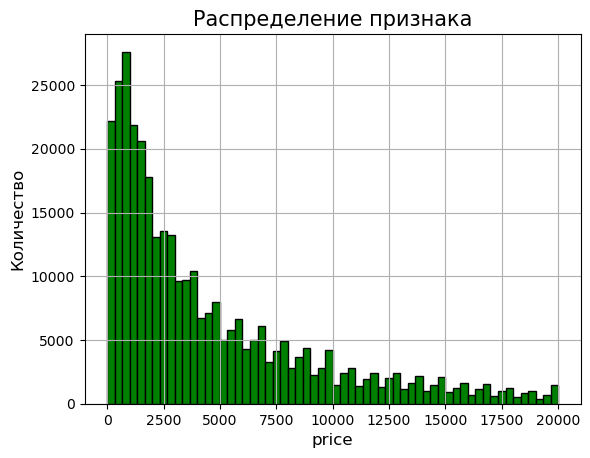

In [14]:
hst(data, 'price')

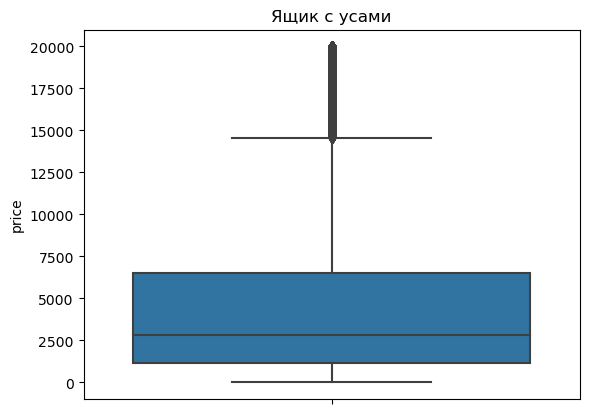

In [15]:
bxplt(data, 'price')

count    334660.000000
mean       2003.924024
std          69.377633
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


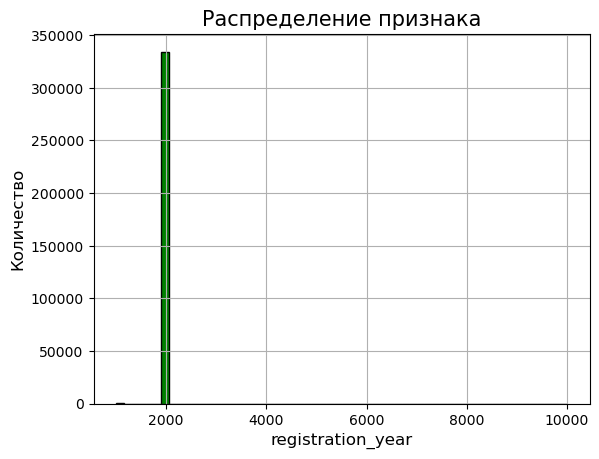

In [16]:
hst(data, 'registration_year')

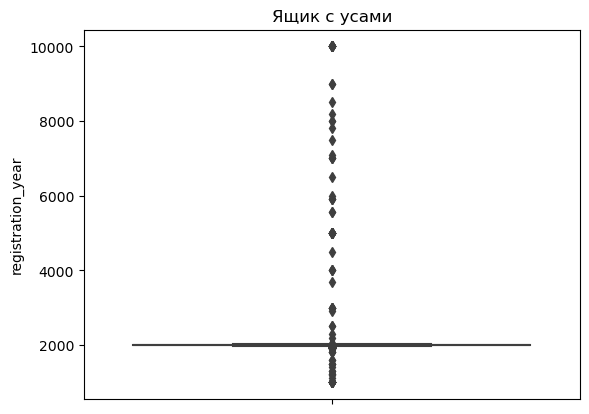

In [17]:
bxplt(data, 'registration_year')

In [18]:
data.registration_year.value_counts().sort_values().tail(10)

registration_year
2007    16716
1998    16834
2002    18325
2004    19094
2003    19120
2001    19282
2006    19332
2005    21003
1999    21605
2000    22248
Name: count, dtype: int64

count    334660.000000
mean     128562.795076
std       37205.638630
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


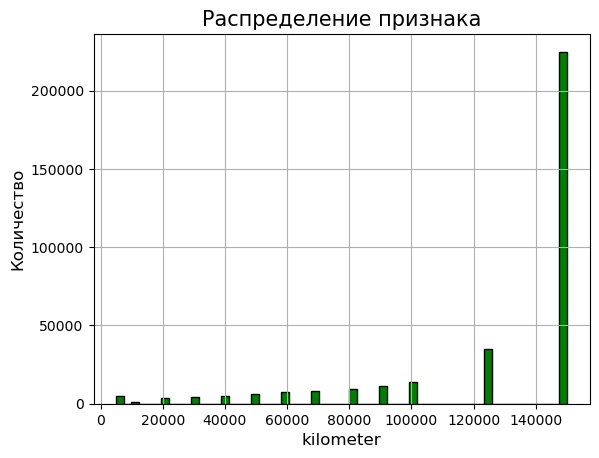

In [19]:
hst(data, 'kilometer')

In [20]:
data.kilometer.value_counts().sort_values()

kilometer
10000       1045
20000       3616
30000       4199
40000       4706
5000        4887
50000       5975
60000       7177
70000       8252
80000       9682
90000      11151
100000     14069
125000     34952
150000    224949
Name: count, dtype: int64

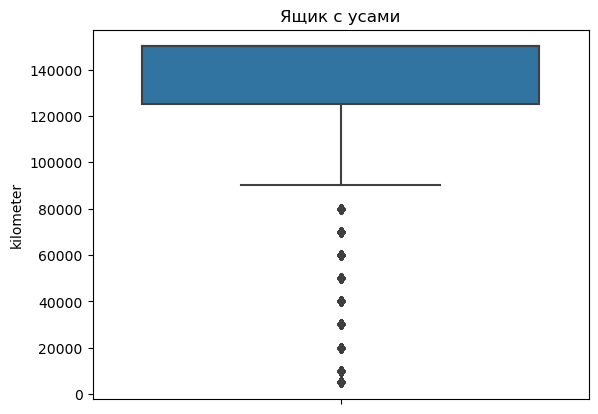

In [21]:
bxplt(data, 'kilometer')

count    334660.000000
mean          5.806075
std           3.689157
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


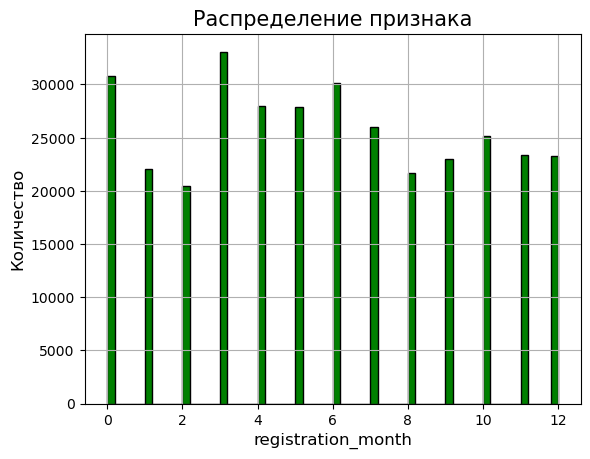

In [22]:
hst(data, 'registration_month')

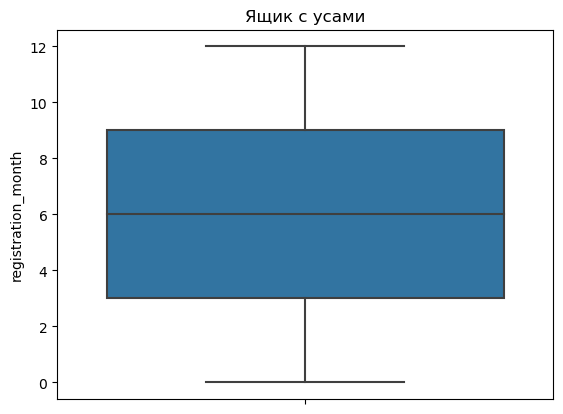

In [23]:
bxplt(data, 'registration_month')

count    334660.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


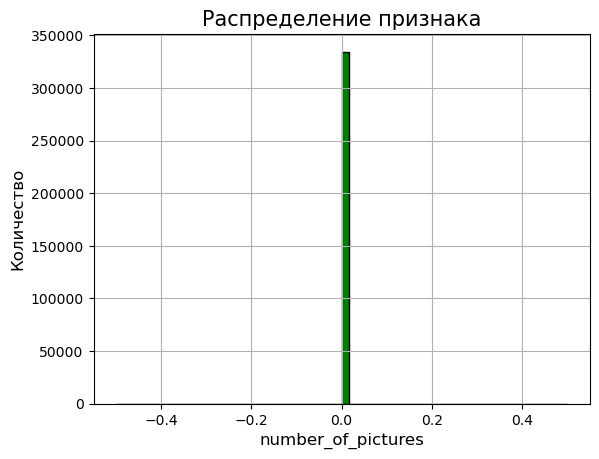

In [24]:
hst(data, 'number_of_pictures')

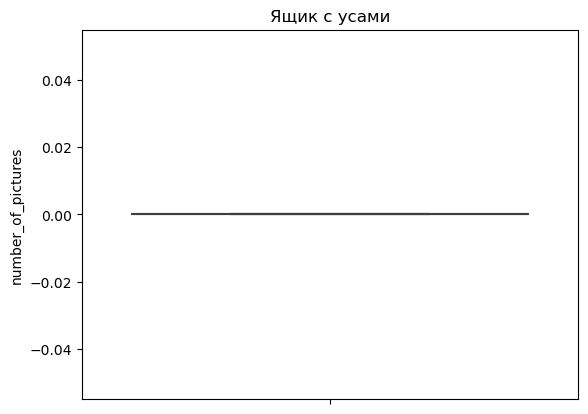

In [25]:
bxplt(data, 'number_of_pictures')

count    334660.000000
mean      50671.327365
std       25754.527341
min        1067.000000
25%       30419.000000
50%       49525.000000
75%       71229.000000
max       99998.000000
Name: postal_code, dtype: float64


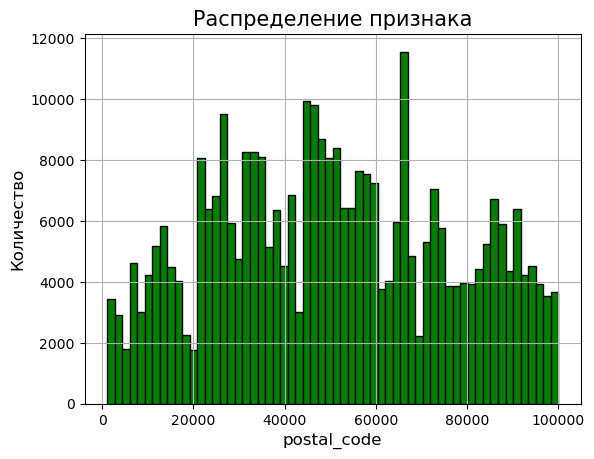

In [26]:
hst(data, 'postal_code')

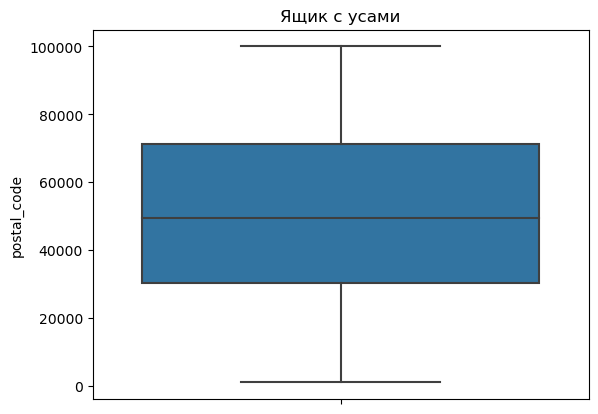

In [27]:
bxplt(data, 'postal_code')

count    334660.000000
mean        111.372659
std         185.157391
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


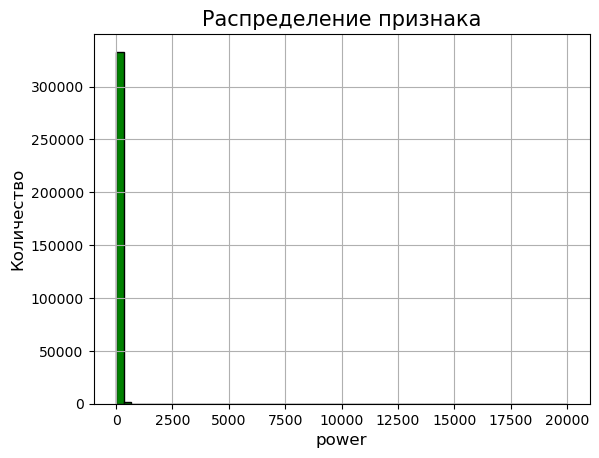

In [28]:
hst(data, 'power')

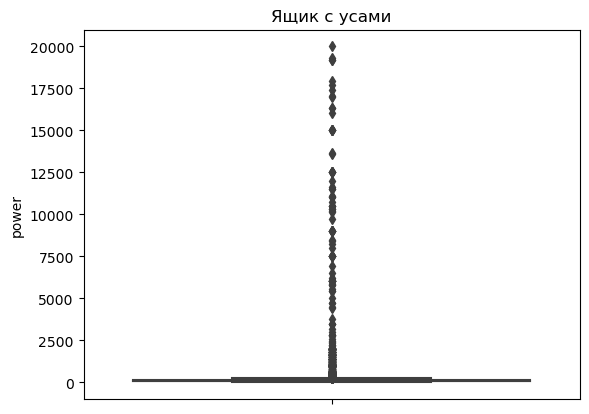

In [29]:
bxplt(data, 'power')

удалим выбросы и аномалии)

In [30]:
data = data.query('price > 0')

In [31]:
data = data.query('1990 <= registration_year <= 2016')

In [32]:
data = data.query('50 <= power <= 500')

count    275149.000000
mean        122.106495
std          52.478526
min          50.000000
25%          80.000000
50%         115.000000
75%         150.000000
max         500.000000
Name: power, dtype: float64


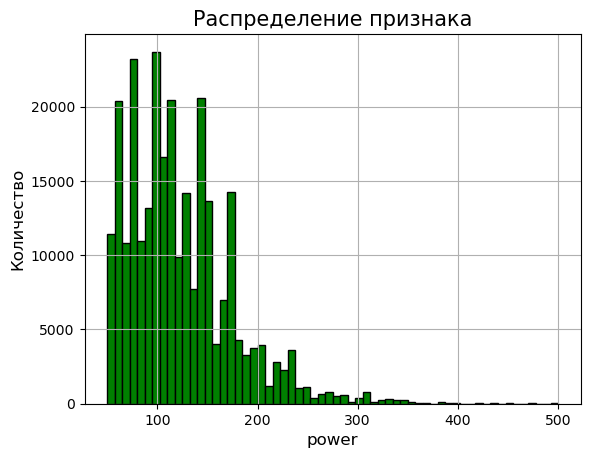

In [33]:
hst(data, 'power')

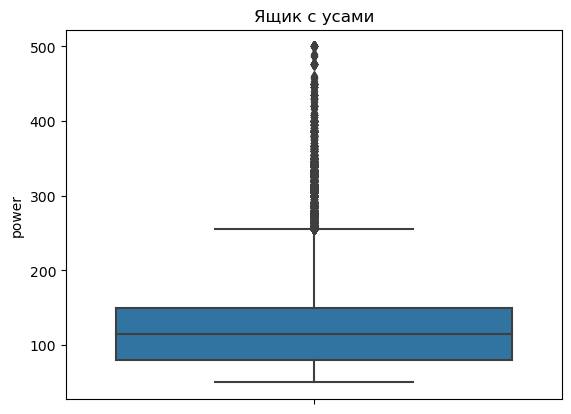

In [34]:
bxplt(data, 'power')

count    275149.000000
mean       2003.451970
std           5.454107
min        1990.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


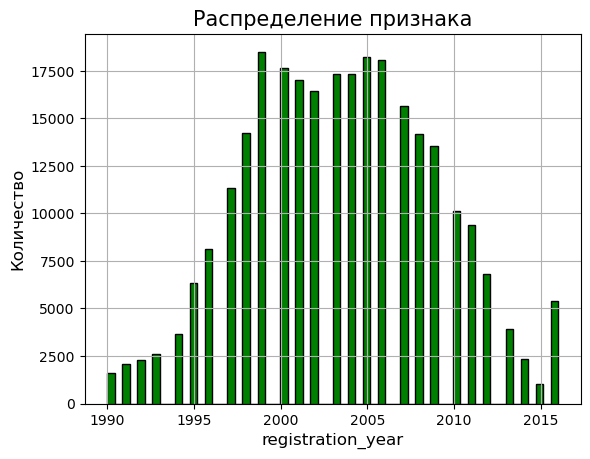

In [35]:
hst(data, 'registration_year')

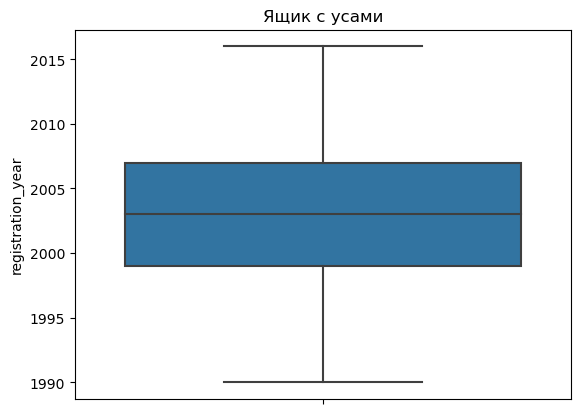

In [36]:
bxplt(data, 'registration_year')

Теперь с данными все в порядке)

Сейчас проведем корреляционный анализ, избавимся от ненужных признаков и подготовим данные к обучению модели) Сразу удалим 'number_of_pictures' 

In [37]:
data = data.drop('number_of_pictures', axis=1)

In [38]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])

# Удаляем текстовые столбцы, чтобы оставить только числовые
numeric_data = data.select_dtypes(include=['number'])

# Вычисляем корреляционную матрицу
correlation_matrix = numeric_data.corr()

# Вывод корреляционной матрицы
display(correlation_matrix)

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.620802,0.508000,-0.401732,0.064290,0.062123
registration_year,0.620802,1.000000,0.120626,-0.427425,0.031987,0.033384
power,0.508000,0.120626,1.000000,0.102782,0.037830,0.050922
kilometer,-0.401732,-0.427425,0.102782,1.000000,-0.018731,-0.012880
registration_month,0.064290,0.031987,0.037830,-0.018731,1.000000,0.001016
postal_code,0.062123,0.033384,0.050922,-0.012880,0.001016,1.000000


Смело выбрасываем признаки registration_month и postal_code, также если подумать нам не понадобяться такие признаки как, дата скачивания анкеты из базы, дата создания анкеты, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя, то есть признаки никак не касаются самого авто)

In [39]:
data = data.drop(['postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [40]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['power', 'price']

In [41]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(data, interval_cols=interval_cols)
print(phik_overview.shape) 

(10, 10)


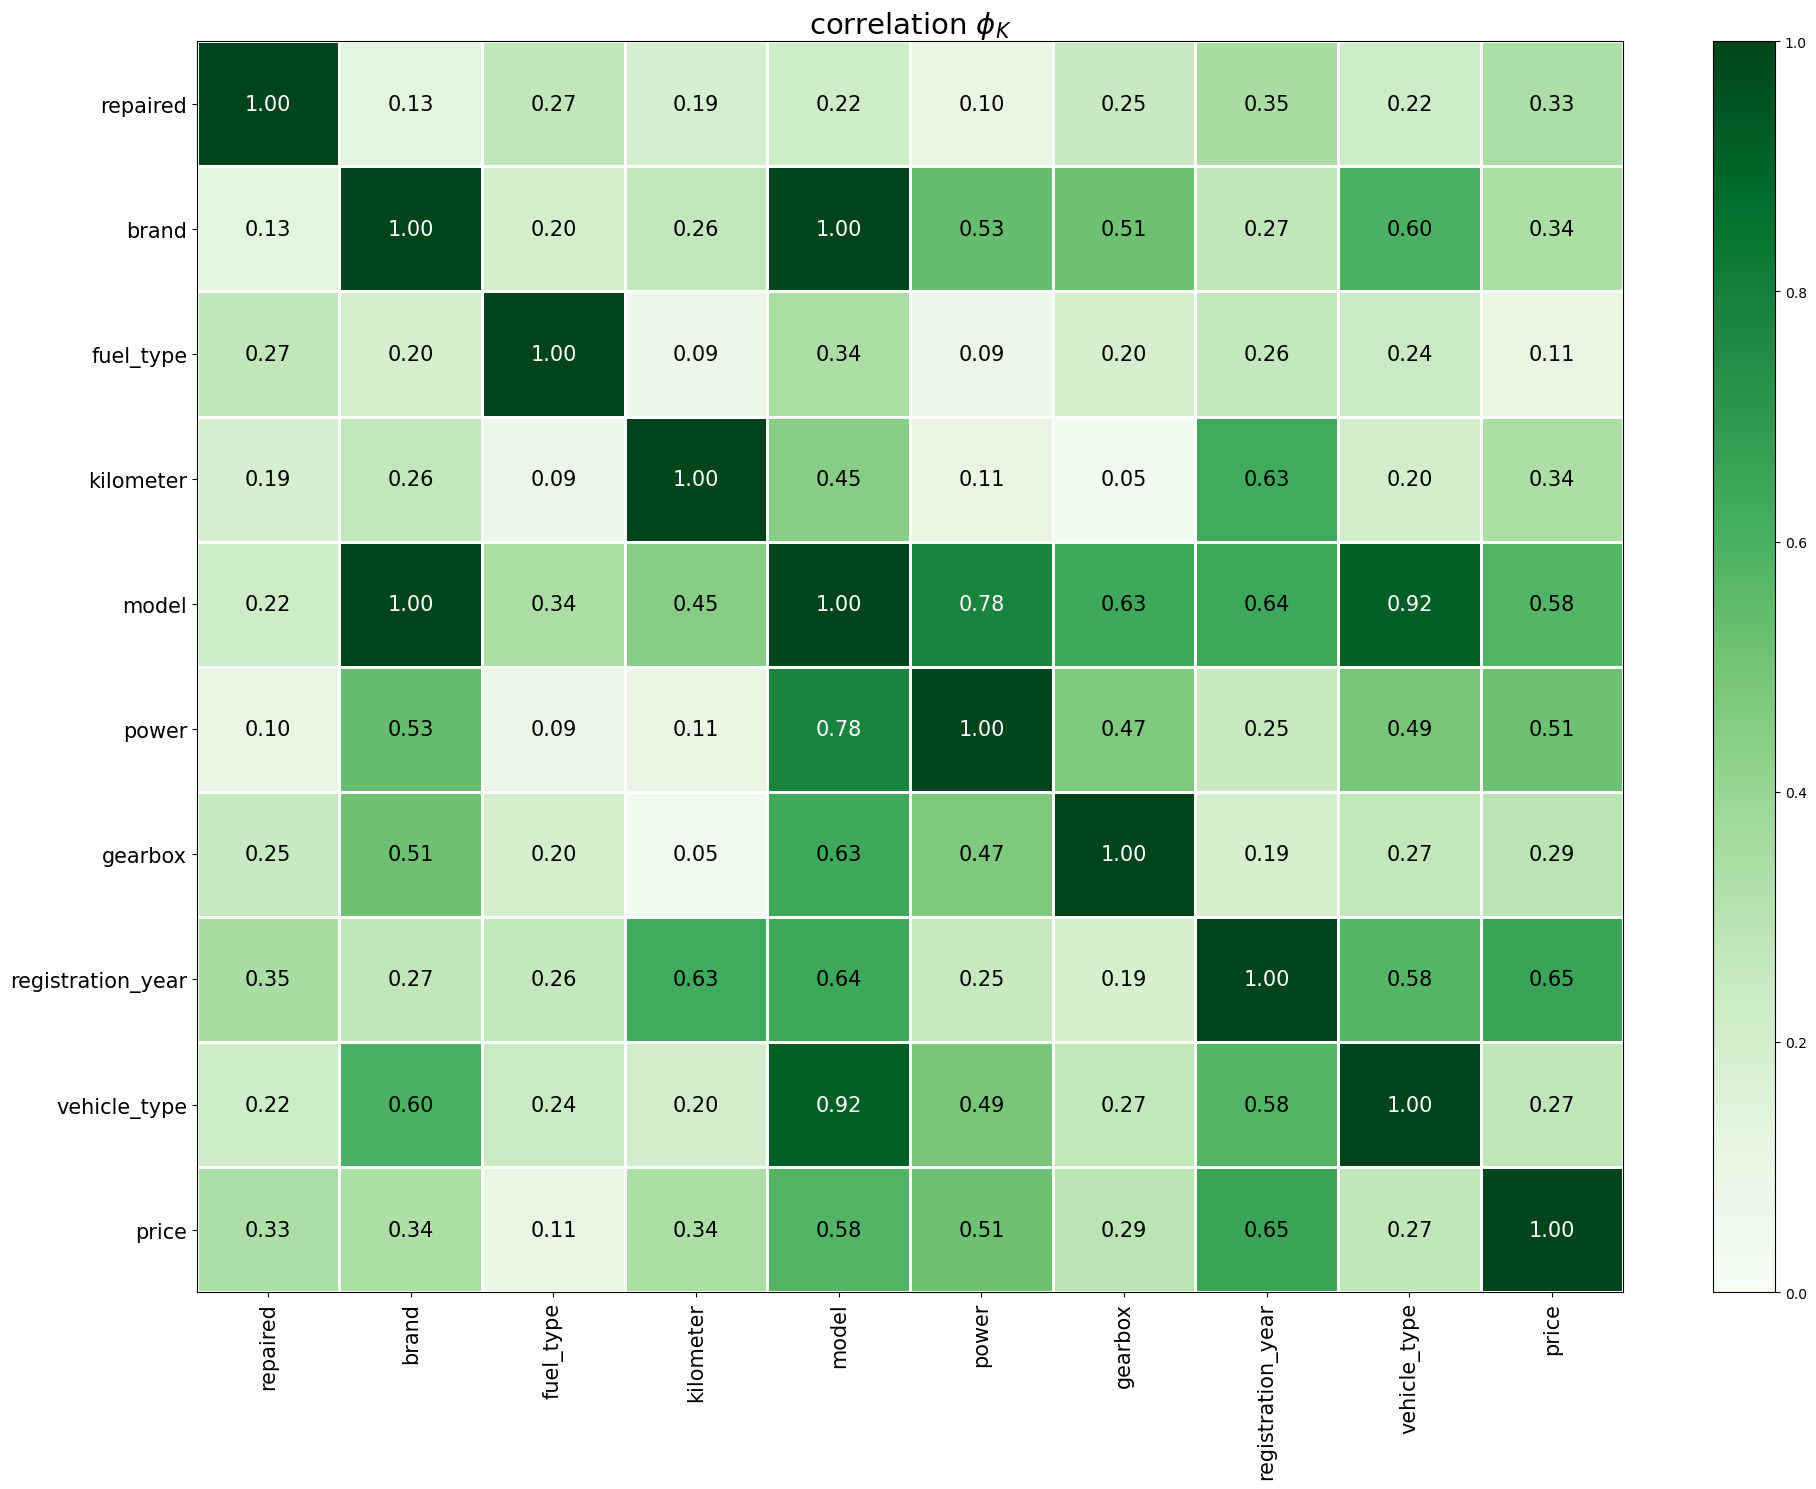

In [42]:
# Функции передаём значения матрицы корреляции phik_overview.values.
# Указываем наименования столбцов x_labels=phik_overview.columns.
# Указываем наименования строк y_labels=phik_overview.index.
# Указываем цвет градиентной отрисовки vmin=0, vmax=1, color_map='Greens'.
# Добавляем заголовок title=r'correlation $\phi_K$'.
# Увеличиваем размер шрифта fontsize_factor=1.5.
# Увеличиваем размер графика figsize=(20, 15).

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [43]:
data = data.drop(['brand'], axis=1)

In [44]:
check_data(data)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 275149 entries, 1 to 334659
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              275149 non-null  int64 
 1   vehicle_type       275149 non-null  object
 2   registration_year  275149 non-null  int64 
 3   gearbox            275149 non-null  object
 4   power              275149 non-null  int64 
 5   model              275149 non-null  object
 6   kilometer          275149 non-null  int64 
 7   fuel_type          275149 non-null  object
 8   repaired           275149 non-null  object
dtypes: int64(4), object(5)
memory usage: 21.0+ MB
первые 5 строк *****************************************************************************************************


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
1,9800,suv,2004,auto,163,grand,125000,petrol,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,no
3,3600,small,2008,manual,69,fabia,90000,petrol,no
4,650,sedan,1995,manual,102,3er,150000,petrol,yes
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,no


название столбцов **************************************************************************************************


Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'repaired'],
      dtype='object')

количество пропусков ***********************************************************************************************
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
repaired             0
dtype: int64
количество явных дубликатов ********************************************************************************************
38500


,count,mean,std,min,25%,50%,75%,max
price,275149.0,4944.665269,4623.284828,1.0,1400.0,3300.0,7000.0,20000.0
registration_year,275149.0,2003.451970,5.454107,1990.0,1999.0,2003.0,2007.0,2016.0
power,275149.0,122.106495,52.478526,50.0,80.0,115.0,150.0,500.0
kilometer,275149.0,128549.513173,36362.081897,5000.0,125000.0,150000.0,150000.0,150000.0


Проведем последние шаги по подготовке данных и самих тренировочных и тестовых выборок

In [45]:
data = data.drop_duplicates().reset_index(drop=True)

In [46]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

На данном этапе была проделана следующая работа:
- Выгружены данные
- Данные изучены, заполнены пропущенные значения и обработаны аномалии в столбцах, удалены неинформативные признаки
- Подготовлены выборки для обучения моделей.

## Обучение моделей

Были выбраны 2 модели для обучения =>  LinearRegression() и LightGBM()

### Линейная регрессия

In [47]:
# Кодируем категориальные признаки с помощью OneHotEncoder.
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

In [48]:
cat_col_names = ['vehicle_type', 'model', 'fuel_type', 'gearbox', 'repaired']

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

# Масштабируем количественные признаки с помощью StandardScaler.
scaler = StandardScaler()
num_col_names = ['registration_year', 'power', 'kilometer']

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
model_lr = LinearRegression()
param_grid = {'fit_intercept': [True, False], 'copy_X': [True, False], 'n_jobs': [1, -1]}

In [50]:
gs= GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

best_params_lr = gs.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lr = LinearRegression(**best_params_lr)

start_fit_time = time.time()
# Обучаем модель на всем обучающем наборе данных
best_model_lr.fit(X_train, y_train)

fit_time_lr = time.time() - start_fit_time

In [51]:
start_predict_time = time.time()
predictions_lr = best_model_lr.predict(X_train)
predict_time_lr = time.time() - start_predict_time

In [55]:
# Оценка RMSE с кросс-валидацией
cv_rmse_lr = cross_val_score(best_model_lr, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
rmse_lr = np.sqrt(-cv_rmse_lr)

print("Лучшие гиперпараметры модели LinearRegression: ", best_params_lr)
print("RMSE LinearRegression (кросс-валидация): %.2f" % rmse_lr.mean())

Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}
RMSE LinearRegression (кросс-валидация): 2384.03


Значение метрики меньше 2500

### LightGBM

In [56]:
y_lgb = data['price']
X_lgb = data.drop('price', axis=1)

for column in X_lgb.columns:
  col_type = X_lgb[column].dtype
  if col_type == 'object':
    X_lgb[column] = X_lgb[column].astype('category')

X_lgb_train, X_lgb_test, y_lgb_train, y_lgb_test = train_test_split(X_lgb, y_lgb, test_size=0.25, random_state=42) 

print(X_lgb_train.shape)
print(X_lgb_test.shape)

(177486, 8)
(59163, 8)


In [57]:
# Задаем параметры для поиска по сетке
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

model = lgb.LGBMRegressor(random_state=12345)

gs = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

# Обучаем с помощью кросс-валидации
gs.fit(X_lgb_train, y_lgb_train)

# Получаем лучшие гиперпараметры
best_params_lg = gs.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lg = LGBMRegressor(**best_params_lg)

start_fit_time = time.time()
# Обучаем модель на всем обучающем наборе данных
best_model_lg.fit(X_lgb_train, y_lgb_train)
fit_time_lg = time.time() - start_fit_time

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 118324, number of used features: 8
[LightGBM] [Info] Start training from score 5050.109192
[CV 1/3] END n_estimators=100, num_leaves=20;, score=-1596.657 total time=   0.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 118324, number of used features: 8
[LightGBM] [Info] Start training from score 5060.723818
[CV 2/3] END n_estimators=100, num_leave

In [58]:
start_predict_time = time.time()
predictions_lg = best_model_lg.predict(X_lgb_train)
predict_time_lg = time.time() - start_predict_time

In [59]:
# Оценка RMSE с кросс-валидацией
cv_rmse_lg = cross_val_score(best_model_lg, X_lgb_train, y_lgb_train, scoring='neg_mean_squared_error', cv=3)
rmse_lg = np.sqrt(-cv_rmse_lg)

print("Лучшие гиперпараметры модели LGBMRegressor: ", best_params_lg)
print("RMSE LGBMRegressor (кросс-валидация): %.2f" % rmse_lg.mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 118324, number of used features: 8
[LightGBM] [Info] Start training from score 5050.109192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 118324, number of used features: 8
[LightGBM] [Info] Start training from score 5060.723818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

Значение метрики меньше 2500

Итак модели обучены и получен следующий результат) 
- Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}, RMSE = 2384.03
- Лучшие гиперпараметры модели LGBMRegressor:  {'n_estimators': 500, 'num_leaves': 100}, RMSE = 1534.97

## Анализ моделей

In [61]:
results = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM'], 'Время обучения(с)': [fit_time_lr, fit_time_lg], 'Время предсказания (с)': [predict_time_lr, predict_time_lg], 'RMSE (кросс-валидация)': [rmse_lr.mean(), rmse_lg.mean()]})
display(results)

,Model,Время обучения(с),Время предсказания (с),RMSE (кросс-валидация)
0,Linear Regression,3.525436,0.181791,2384.029411
1,LightGBM,2.094735,2.191136,1534.966424


 Был проведен анализ и выявлено - лучшей из обученных моделей для рекомендации ее заказчику становиться модель  LGBMRegressor: {'n_estimators': 500, 'num_leaves': 100}. Проверим ее на тестовой выборке)

In [62]:
# RMSE LightGBM на тестовой выборке
rmse_test = mean_squared_error(y_lgb_test, best_model_lg.predict(X_lgb_test), squared=False)
print("RMSE LGBMRegressor на тестовой выборке: %.2f" % rmse_test)

RMSE LGBMRegressor на тестовой выборке: 1511.55


Идеально превосходно прекрасно стильно модно молодежно, метрика на тестовой выборке меньше 2500, и по времени она все делает быстро, значит ее можно рекомендовать заказчику для дальнейшей работы с ней)

## Общий вывод

Для решения поставленной задачи по разработке модели для определения рыночной стоимости автомобиля была проделана работа:

1) Выгружены данные, данные изучены, заполнены пропущенные значения и обработаны аномалии в столбцах, удалены неинформативные признаки, подготовлены выборки для обучения моделей.

2) Обучены модели LinReg и LGBMRegressor

3) Проведен анализ и выявлен фаворит исходя из запросов заказчика: LGBMRegressor: {'n_estimators': 500, 'num_leaves': 100} -  лучшая модель так как ее rmse и на тестовой выборке и на тренирововчной намного 2500 и намного меньше чем у LinReg), также эта модель довольно быстрая и ее время обучения и предсказания не превышает 5 секунд). И так как для заказчика важны эти 3 критерия(качество предсказания; время обучения модели; время предсказания модели), то данную модель совершенно точно можно рекомендовать без всяких опасений)